<b>

<p>
<center>
<font size="5">
Machine Learning I (DATS 6202), Fall 2019
</font>
</center>
</p>

<p>
<center>
<font size="4">
Final Project
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Author: Tanaya Kavathekar
</font>
</center>
</p>

</b>

# Introduction
[YouTube](https://www.kaggle.com/datasnaek/youtube-new)

## Import libraries


In [64]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

## Data

1. US Videos: This is a CSV file having daily records of trending videos 
2. Category ID: This is a mapping of JSON file type. This file gives description of categories ID

In [65]:
# read files
unprocessed_df = pd.read_csv("../Data/US_videos.csv")

# read json file
with open("../Data/US_category_id.json") as train_file:
    categories = json.load(train_file)["items"]
unprocessed_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


## Data preprocessing

In [66]:
def get_category_id(categories):
    """"
    
    Get descriptions of the category ids
    
    Parameters
    ----------
    categories: dataframe
    
    Returns
    ----------
    Dataframe with a new column of categories descriptions
    """
    cat_dict = {}
    for cat in categories:
        cat_dict[int(cat["id"])] = cat["snippet"]["title"]
    return cat_dict

cat_dict = get_category_id(categories)
unprocessed_df['category_name'] = unprocessed_df['category_id'].map(cat_dict)
unprocessed_df.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment


## Filter for the last row

In [67]:
def get_latest_update_video_id(df):
    """"
    
    Get latest updated row corresponding to a video
    
    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    Dataframe at a video id level
    """
    
    idx = df.groupby(['video_id'])['trending_date'].transform(max) == df['trending_date']

    df = df[idx]
    return df
unprocessed_df = get_latest_update_video_id(unprocessed_df)


## Missing value check

In [68]:
def missing_value_checker(df):
    """
    The missing value checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The variables with missing value and their proportion of missing value
    """
    
    variable_proportion = [[variable, df[variable].isna().sum() / df.shape[0]] 
                           for variable in df.columns 
                           if df[variable].isna().sum() > 0]

    print('%-30s' % 'Variable with missing values', 'Proportion of missing values')
    for variable, proportion in sorted(variable_proportion, key=lambda x : x[1]):
        print('%-30s' % variable, proportion)
        
    return variable_proportion
variable_proportion = missing_value_checker(unprocessed_df)
# Only desc has nulls 

Variable with missing values   Proportion of missing values
description                    0.015423355366698142


## Data Summary

In [69]:
#df statistics
unprocessed_df.describe()

,category_id,views,likes,dislikes,comment_count
count,6354.000000,6.354000e+03,6.354000e+03,6.354000e+03,6.354000e+03
mean,20.428706,1.770834e+06,5.307986e+04,2.940530e+03,6.284698e+03
std,7.230658,6.045192e+06,1.840270e+05,3.181381e+04,3.341908e+04
min,1.000000,5.590000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,1.544638e+05,2.702500e+03,1.230000e+02,3.652500e+02
50%,24.000000,4.951385e+05,1.171650e+04,4.335000e+02,1.234500e+03
75%,25.000000,1.386434e+06,3.736675e+04,1.440250e+03,4.000750e+03
max,43.000000,2.177501e+08,5.595203e+06,1.674420e+06,1.361580e+06


We first need to define popularity levels. The levels can be defined using #comments. #views, #likes and #dislikes. 
Lets analyze the distribution of these variables. As the scale of the variables is really high the variables are transformed
on a log scale

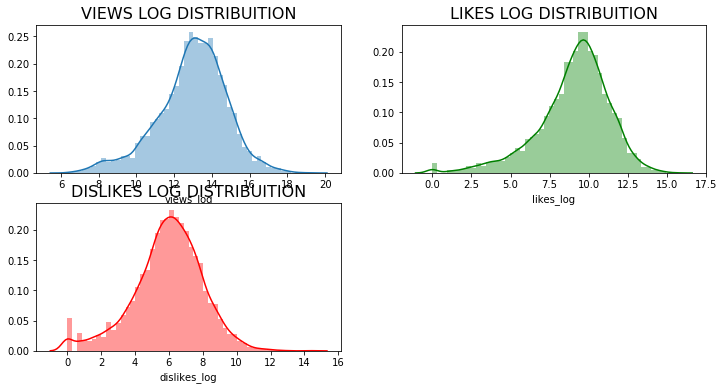

In [70]:
unprocessed_df[['views_log', 'dislikes_log', 'likes_log']] = np.log(unprocessed_df[['views', 'dislikes', 'likes']] +1)

plt.figure(figsize = (12,6))
plt.subplot(221)
g1 = sns.distplot(unprocessed_df['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g2 = sns.distplot(unprocessed_df['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(unprocessed_df['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUITION", fontsize=16)

plt.show()



## Outlier detection and treatment

In [71]:
def outlier_treatment(df):
    """
    
    Values lying outside 3SD are considered as outliers for this analysis
    Outlier values are treated with mean of that column
    
    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    Dataframe with treated outlier values
    """
    
    for col in ["likes", "dislikes", "views", "comment_count"]:
        outliers = df[(np.abs(stats.zscore(df[col]))>3)][col]
        print("Total outlier points for " +col+ ":", len(outliers))
        df.loc[outliers.index, col] = df[col].mean()
    return df

unprocessed_df = outlier_treatment(unprocessed_df)


Total outlier points for likes: 78
Total outlier points for dislikes: 19
Total outlier points for views: 75
Total outlier points for comment_count: 40


## Month wise distribution for published time

Text(0,0.5,'Count')

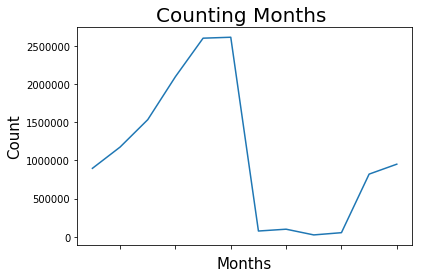

In [84]:
unprocessed_df['publish_time'] = pd.to_datetime(unprocessed_df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
unprocessed_df['published_month'] = unprocessed_df['publish_time'].dt.month

# average views per month

avg_mon_views = unprocessed_df.groupby(["published_month"], as_index=False).agg({'views':'mean'})
avg_mon_views.head()
# plt.subplot(211)
g = sns.lineplot(x = 'published_month', y = "views", data=avg_mon_views, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Months ", fontsize=20)
g.set_xlabel("Months", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Months from june till Nov has very less published videos. Maximum videos are published in the month of May.


## Month wise distribution for trending date

In [27]:
unprocessed_df['trending_date'] = pd.to_datetime(unprocessed_df['trending_date'], format='%y.%d.%m')
unprocessed_df['trending_month'] = unprocessed_df['trending_date'].dt.month

# plt.subplot(211)
# g = sns.countplot('trending_month', data=unprocessed_df, palette="Set1")
# g.set_xticklabels(g.get_xticklabels(),rotation=45)
# g.set_title("Counting Months ", fontsize=20)
# g.set_xlabel("Months", fontsize=15)
# g.set_ylabel("Count", fontsize=15)

Months from june till Nov do not have trending data.

## Day wise distribution for published time

In [28]:
unprocessed_df['publish_time_dayofweek'] = unprocessed_df['publish_time'].dt.dayofweek+1
# plt.subplot(211)
# g = sns.countplot('publish_time_dayofweek', data=unprocessed_df, palette="Set1")
# g.set_xticklabels(g.get_xticklabels(),rotation=45)
# g.set_title("Counting dayofweek", fontsize=20)
# g.set_xlabel("Day of week", fontsize=15)
# g.set_ylabel("Count", fontsize=15)

In [29]:
unprocessed_df['publish_weekend'] = unprocessed_df['publish_time_dayofweek']>5
unprocessed_df.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,published_month,trending_month,publish_time_dayofweek,publish_weekend
10,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377.0,655.0,25.0,...,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,Sports,11,11,1,False
36,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922.0,7515.0,792.0,...,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,Film & Animation,11,11,7,True


Surprisingly weekends (6 & 7) has less published videos that weekdays


## Day wise distribution for trending date

In [30]:
unprocessed_df['trending_dayofweek'] = unprocessed_df['trending_date'].dt.dayofweek+1
# 
# print(unprocessed_df['trending_dayofweek'].value_counts())
# plt.subplot(211)
# g = sns.countplot('trending_dayofweek', data=unprocessed_df, palette="Set1")
# g.set_xticklabels(g.get_xticklabels(),rotation=45)
# g.set_title("Counting Months ", fontsize=20)
# g.set_xlabel("Months", fontsize=15)
# g.set_ylabel("Count", fontsize=15)

In [31]:
unprocessed_df['trending_weekend'] = unprocessed_df['trending_dayofweek']>5
unprocessed_df.head(2)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,ratings_disabled,video_error_or_removed,description,category_name,published_month,trending_month,publish_time_dayofweek,publish_weekend,trending_dayofweek,trending_weekend
10,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377.0,655.0,25.0,...,False,False,New England Patriots returner Dion Lewis blast...,Sports,11,11,1,False,2,False
36,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922.0,7515.0,792.0,...,False,False,With Justice League approaching fast we rewatc...,Film & Animation,11,11,7,True,2,False


All weeks have more or less same trending counts in the data

In [32]:
# separates date and time into two columns from 'publish_time' column
unprocessed_df['time'] = unprocessed_df['publish_time'].dt.time

unprocessed_df[['hour','min','sec']] = unprocessed_df['time'].astype(str).str.split(':', expand=True).astype(int)

unprocessed_df['hour'][:5]

10     2
36    18
41    21
55    19
76    12
Name: hour, dtype: int32

Text(0,0.5,'Count')

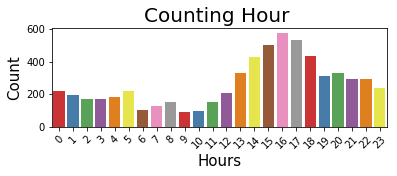

In [33]:
plt.subplot(211)
g = sns.countplot('hour', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Text(0,0.5,'Count')

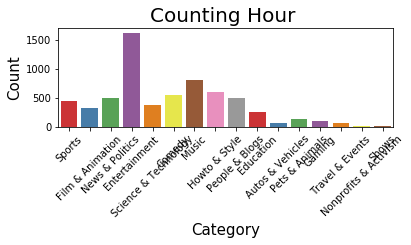

In [34]:
plt.subplot(212)
g = sns.countplot('category_name', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Category", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Maximum videos are published during 15,16,17 hours. 

## Visualizing title data with wordcloud

In [ ]:
# plt.figure(figsize = (15,15))

# stopwords = set(STOPWORDS)
# wordcloud = WordCloud(
#                           background_color='black',
#                           stopwords=stopwords,
#                         
max_words=150,
#                           max_font_size=40, 
#                           random_state=42
#                          ).generate(str(unprocessed_df['title']))

# print(wordcloud)
# fig = plt.figure(1)
# plt.imshow(wordcloud)
# plt.title("WORD CLOUD - DESCRIPTION")
# plt.axis('off')
# plt.show()

In [35]:
#Word count in each comment:
unprocessed_df['count_word']=unprocessed_df["title"].apply(lambda x: len(str(x).split()))
unprocessed_df['count_word_tags']=unprocessed_df["tags"].apply(lambda x: len(str(x).split()))

#Unique word count
unprocessed_df['count_unique_word']=unprocessed_df["title"].apply(lambda x: len(set(str(x).split())))
unprocessed_df['count_unique_word_tags']=unprocessed_df["tags"].apply(lambda x: len(set(str(x).split())))

unprocessed_df['count_tags']=unprocessed_df["tags"].apply(lambda x: len(set(str(x).split("|"))))


In [36]:
def outcome(unprocessed_df, w1,w2,w3, num):
    print(w3)
    
    unprocessed_df['neutral'] = unprocessed_df['views']-unprocessed_df['likes']-unprocessed_df['dislikes']
    
    y = w1*unprocessed_df['likes']+w2*unprocessed_df['neutral']+w3*unprocessed_df['dislikes']
    y.sum()
    unprocessed_df["y_cat_"+ str(num)] =pd.qcut(y ,3,labels=["low", "medium", "high"])  
    return unprocessed_df

unprocessed_df = outcome(unprocessed_df, 1/3,1/3,1/3, 1) # equally important
unprocessed_df = outcome(unprocessed_df, 1/2,1/4,1/4, 2) # likes more important
unprocessed_df = outcome(unprocessed_df, 1/2,3/8,1/8, 3) # likes more important

0.3333333333333333
0.25
0.125


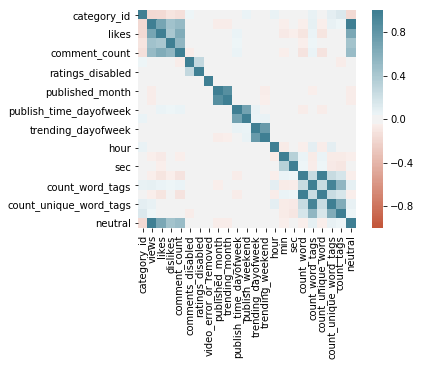

In [37]:
corr = unprocessed_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [38]:
unprocessed_df['timediff'] = (unprocessed_df['trending_date'] - unprocessed_df['publish_time']).dt.days
unprocessed_df['timediff'][:5]

10    0
36    1
41    1
55    3
76    3
Name: timediff, dtype: int64

In [41]:
target = 'y_cat_1'
y = unprocessed_df['y_cat_1']
X = unprocessed_df[['timediff', 'comments_disabled', 'ratings_disabled', 'comment_count',
       'video_error_or_removed', 'category_name', 'published_month', 'trending_month',
       'publish_weekend','trending_weekend','hour', 'count_word',
       'count_tags']]

In [42]:
def categorical_feature_checker(df, target, dtype):
    """
    The categorical feature checker

    Parameters
    ----------
    df : dataframe
    target : the target
    dtype : the type of the feature
    
    Returns
    ----------
    The categorical features and their number of unique value
    """
    
    feature_number = [[feature, df[feature].nunique()] 
                      for feature in df.columns 
                      if feature != target and df[feature].dtype.name == dtype]
    
    print('%-30s' % 'Categorical feature', 'Number of unique value')
    for feature, number in sorted(feature_number, key=lambda x : x[1]):
        print('%-30s' % feature, number)
    
    return feature_number
feature_number = categorical_feature_checker(X, target, 'object')

# Print the unique value and their number for the target
y.value_counts()

Categorical feature            Number of unique value
category_name                  16


high      2118
medium    2118
low       2118
Name: y_cat_1, dtype: int64

## Separate train and test to predict the model

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.02)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

clfs = {'lr': LogisticRegression(random_state=0),
        'mlp': MLPClassifier(random_state=0),
        'dt': DecisionTreeClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0),
        'xgb': XGBClassifier(seed=0),
        'svc': SVC(random_state=0),
        'knn': KNeighborsClassifier(),
        'gnb': GaussianNB()}

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_clfs = {}

for name, clf in clfs.items():
    # Implement me
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])
    

In [45]:
param_grids = { }
# logistic
C_range = [10 ** i for i in range(-4, 5)]

param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]

param_grids['lr'] = param_grid

# MLP
param_grid = [{'clf__hidden_layer_sizes': [10, 100],
               'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

param_grids['mlp'] = param_grid

# Decision tree
param_grid = [{'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['dt'] = param_grid

# Random forest
param_grid = [{'clf__n_estimators': [10, 100],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['rf'] = param_grid

# xgboost
param_grid = [{'clf__learning_rate': [10 ** i for i in range(-4, 1)],
               'clf__gamma': [0, 10, 100],
               'clf__reg_lambda': [10 ** i for i in range(-4, 5)]}]

param_grids['xgb'] = param_grid
# SVC
param_grid = [{'clf__C': [10 ** i for i in range(-4, 5)],
               'clf__gamma': ['auto', 'scale']}]

param_grids['svc'] = param_grid

#Knn
param_grid = [{'clf__n_neighbors': list(range(1, 11))}]

param_grids['knn'] = param_grid

#GNB
param_grid = [{'clf__var_smoothing': [10 ** i for i in range(-10, -7)]}]

param_grids['gnb'] = param_grid
param_grids

{'lr': [{'clf__multi_class': ['ovr'],
   'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
   'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
  {'clf__multi_class': ['multinomial'],
   'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
   'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
 'mlp': [{'clf__hidden_layer_sizes': [10, 100],
   'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}],
 'dt': [{'clf__min_samples_split': [2, 10, 30],
   'clf__min_samples_leaf': [1, 10, 30]}],
 'rf': [{'clf__n_estimators': [10, 100],
   'clf__min_samples_split': [2, 10, 30],
   'clf__min_samples_leaf': [1, 10, 30]}],
 'xgb': [{'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
   'clf__gamma': [0, 10, 100],
   'clf__reg_lambda': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
 'svc': [{'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
   'clf__gamma': ['auto', 'scale']}],
 'knn': [{'clf__n_neighbors': [1, 2, 3, 4, 5, 6

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

In [47]:
X = pd.get_dummies(data = X)
X.head()

,timediff,comments_disabled,ratings_disabled,comment_count,video_error_or_removed,published_month,trending_month,publish_weekend,trending_weekend,hour,...,category_name_Howto & Style,category_name_Music,category_name_News & Politics,category_name_Nonprofits & Activism,category_name_People & Blogs,category_name_Pets & Animals,category_name_Science & Technology,category_name_Shows,category_name_Sports,category_name_Travel & Events
10,0,False,False,177.0,False,11,11,False,False,2,...,0,0,0,0,0,0,0,0,1,0
36,1,False,False,2111.0,False,11,11,True,False,18,...,0,0,0,0,0,0,0,0,0,0
41,1,False,False,413.0,False,11,11,True,False,21,...,0,0,1,0,0,0,0,0,0,0
55,3,False,False,605.0,False,11,11,False,False,19,...,0,0,0,0,0,0,0,0,0,0
76,3,False,False,260.0,False,11,11,False,False,12,...,0,0,0,0,0,0,1,0,0,0


In [48]:
# For each classifier
for name in pipe_clfs.keys():
    # GridSearchCV
    # Implement me
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=1,
                      iid=False,
                      cv=StratifiedKFold(n_splits=5,
                                         shuffle=True,
                                         random_state=0))
    # Fit the pipeline
    # Implement me
    gs = gs.fit(X, y)
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [50]:
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.7502479295835378, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[0.7496152816807172, {'clf__gamma': 0, 'clf__learning_rate': 1, 'clf__reg_lambda': 1000}, <class 'xgboost.sklearn.XGBClassifier'>]

[0.7260129057198507, {'clf__activation': 'relu', 'clf__hidden_layer_sizes': 10}, <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>]

[0.7157820003865769, {'clf__C': 100, 'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg'}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]

[0.7127819409132135, {'clf__min_samples_leaf': 30, 'clf__min_samples_split': 2}, <class 'sklearn.tree.tree.DecisionTreeClassifier'>]

[0.6984648438080795, {'clf__C': 100, 'clf__gamma': 'auto'}, <class 'sklearn.svm.classes.SVC'>]

[0.5588689653121609, {'clf__n_neighbors': 7}, <class 'sklearn.neighbors.classification.KNeighborsClassifier'>]

[0.41658266054091025, {'clf__var_smoothing': 1e

In [54]:
# Get the best estimator
best_estimator = best_score_param_estimators[0][2]

In [55]:
y_pred = best_estimator.predict(X_test)

ValueError: could not convert string to float: 'Music'

In [ ]:
# from pydotplus import graph_from_dot_data
# from sklearn.tree import export_graphviz
# from IPython.display import Image
# feature_value_names = X.columns
# dot_data = export_graphviz(best_estimator.named_steps['clf'],
#                            filled=True, 
#                            rounded=True,
#                            feature_names=feature_value_names) 

# graph = graph_from_dot_data(dot_data) 

# Image(graph.create_png()) 
    

In [ ]:
# import matplotlib.pyplot as plt

# # Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
# f_importances = pd.Series(best_estimator.named_steps['clf'].feature_importances_, feature_value_names)

# # Sort the array in descending order of the importances
# f_importances = f_importances.sort_values(ascending=False)

# # Draw the bar Plot from f_importances 
# f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=30)

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# gs.cv_results_

In [ ]:
y_test.shape